In [1]:
from cProfile import label

import yfinance as yf
import pandas as pd
import anaylsis
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
end = dt.datetime.now(anaylsis.timezone)
start = dt.datetime(year=end.year - 10, month=end.month, day=end.day, tzinfo=anaylsis.timezone)

In [3]:
symbol="BSL"
initial_cash = 10000

In [4]:
ticker = yf.Ticker(symbol)
prices = ticker.history(start=start, end=end)
prices.index = pd.to_datetime(prices.index)
prices.index = prices.index.tz_convert(anaylsis.timezone)
prices.to_csv("prices.csv")

In [5]:
div_events = anaylsis.gather_dividends(symbol, start, end)

INFO:root:size: 125, ex_dividend_date: 2024-11-21, symbol: BSL


In [6]:
snowball = anaylsis.dividend_snowball(prices, div_events, 10000)
snowball["value"] = snowball["Close"] * snowball["quantity"]

In [7]:
approaches = []

In [8]:
final_value = snowball.iloc[-1].value
approaches.append(anaylsis.create_approach_summary("Reinvest Dividends", final_value, initial_cash , 0.0))

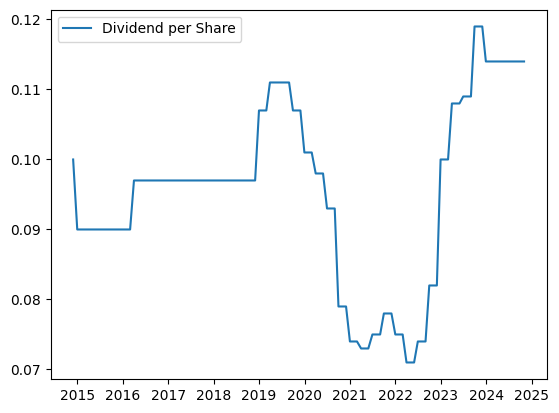

In [15]:
plt.plot(div_events.index, div_events["cash_amount"], label="Dividend per Share")
plt.legend()
plt.show()

In [16]:
dividends_gathered = anaylsis.dividend_keep_the_cash(prices, div_events, initial_cash)

In [17]:
final_value = dividends_gathered.iloc[-1].value
cash_in_bank = dividends_gathered.total_dividend.sum()
approaches.append(anaylsis.create_approach_summary("Keep the Cash", final_value, initial_cash, cash_in_bank))


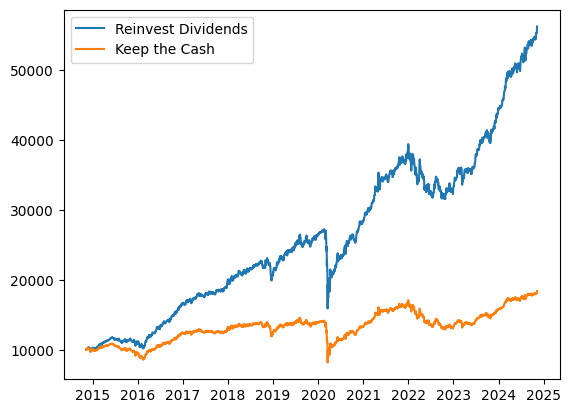

In [18]:
plt.plot(snowball.index, snowball['value'], label='Reinvest Dividends')
plt.plot(dividends_gathered.index, dividends_gathered['value'], label='Keep the Cash')
plt.xlabel = "Date"
plt.ylabel = "Portfolio($)"
plt.legend()
plt.show()

In [19]:
pd.DataFrame(approaches).set_index("Approach")

,Final Market Amount,Market Profit,Market Gain,Cash Kept,Total Profit,Total Gain
Approach,,,,,,
Reinvest Dividends,56178.33,46178.33,461.78,0.00,46178.33,461.78
Keep the Cash,18399.83,8399.83,84.00,14597.36,22997.19,229.97
Keep the Cash,18399.83,8399.83,84.00,14597.36,22997.19,229.97
